# LSTM for time series forcasting


#### Import lib

In [20]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
 
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable 

#!pip install sklearn


#### Carregando a informação

In [5]:
df = pd.read_csv('SBUX.csv', index_col = 'Date', parse_dates=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-11,86.260002,86.870003,85.849998,86.589996,81.991577,4921900
2019-12-12,88.000000,88.889999,87.540001,88.209999,83.525551,10282100
2019-12-13,88.019997,88.790001,87.580002,88.669998,83.961121,6714100
2019-12-16,89.139999,89.300003,88.430000,88.779999,84.065269,6705600
2019-12-17,88.870003,88.970001,87.470001,88.129997,83.449799,7296900


<AxesSubplot: title={'center': 'Star Bucks Stocks Volume'}, xlabel='Date'>

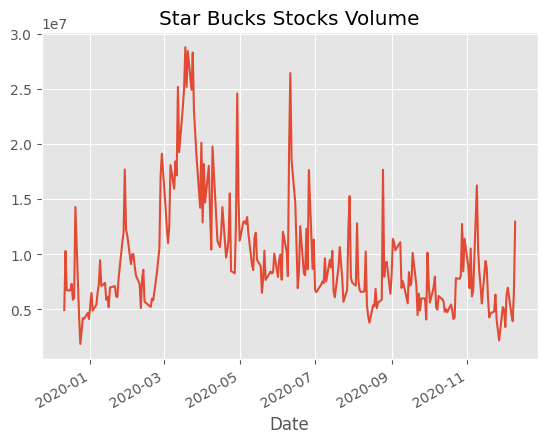

In [11]:
plt.style.use("ggplot")
df["Volume"].plot(label="CLOSE",title="Star Bucks Stocks Volume")

In [18]:
x = df.iloc[:,:-1]
y = df.iloc[:,5:6]

### Data preprocessing

In [22]:
mm = MinMaxScaler()
ss = StandardScaler()

x_ss = ss.fit_transform(x)
y_mm = mm.fit_transform(y)

### Split data

In [26]:
x_train = x_ss[:200,:]
x_test = x_ss[200:,:]

y_train = y_mm[:200,:]
y_test = y_mm[200:,:]

print(f""" Training Shape: {x_train.shape}, {y_train.shape} \n
      Testing Shape: {x_test.shape}, {y_test.shape}""")

 Training Shape: (200, 5), (200, 1) 

      Testing Shape: (53, 5), (53, 1)


### Convert dataset to torch

In [29]:
x_train_tensors = Variable(torch.Tensor(x_train))
x_test_tensors = Variable(torch.Tensor(x_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

In [36]:
x_train_tensors_final = torch.reshape(x_train_tensors,   (x_train_tensors.shape[0], 1, x_train_tensors.shape[1]))


x_test_tensors_final = torch.reshape(x_test_tensors,  (x_test_tensors.shape[0], 1, x_test_tensors.shape[1])) 

#### Implementation LSTM model 

In [38]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out
 

### Training 

In [42]:
num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 5 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

In [43]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, x_train_tensors_final.shape[1]) #our lstm class 

In [44]:
# Loss function and optimizer
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) 

In [45]:
for epoch in range(num_epochs):
  outputs = lstm1.forward(x_train_tensors_final) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
  loss = criterion(outputs, y_train_tensors)
 
  loss.backward() #calculates the loss of the loss function
 
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.12094
Epoch: 100, loss: 0.02095
Epoch: 200, loss: 0.01595
Epoch: 300, loss: 0.01414
Epoch: 400, loss: 0.01189
Epoch: 500, loss: 0.01115
Epoch: 600, loss: 0.01101
Epoch: 700, loss: 0.01093
Epoch: 800, loss: 0.01086
Epoch: 900, loss: 0.01081


### Result

In [47]:
df_X_ss = ss.transform(df.iloc[:, :-1]) #old transformers
df_y_mm = mm.transform(df.iloc[:, -1:]) #old transformers

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1])) 

In [51]:
train_predict = lstm1(df_X_ss)#forward pass
train_predict


tensor([[0.1910],
        [0.2094],
        [0.2007],
        [0.1691],
        [0.2256],
        [0.1825],
        [0.1837],
        [0.1913],
        [0.1523],
        [0.1482],
        [0.1802],
        [0.1630],
        [0.1967],
        [0.1569],
        [0.2058],
        [0.1812],
        [0.1789],
        [0.1783],
        [0.2260],
        [0.1779],
        [0.1972],
        [0.2120],
        [0.1379],
        [0.1724],
        [0.1701],
        [0.1629],
        [0.1957],
        [0.1841],
        [0.3489],
        [0.3089],
        [0.2562],
        [0.2227],
        [0.3442],
        [0.2689],
        [0.2374],
        [0.2486],
        [0.2977],
        [0.2994],
        [0.2182],
        [0.2004],
        [0.2099],
        [0.1556],
        [0.2240],
        [0.2649],
        [0.1947],
        [0.1821],
        [0.1722],
        [0.2887],
        [0.1997],
        [0.2414],
        [0.4260],
        [0.3454],
        [0.4423],
        [0.4152],
        [0.5308],
        [0

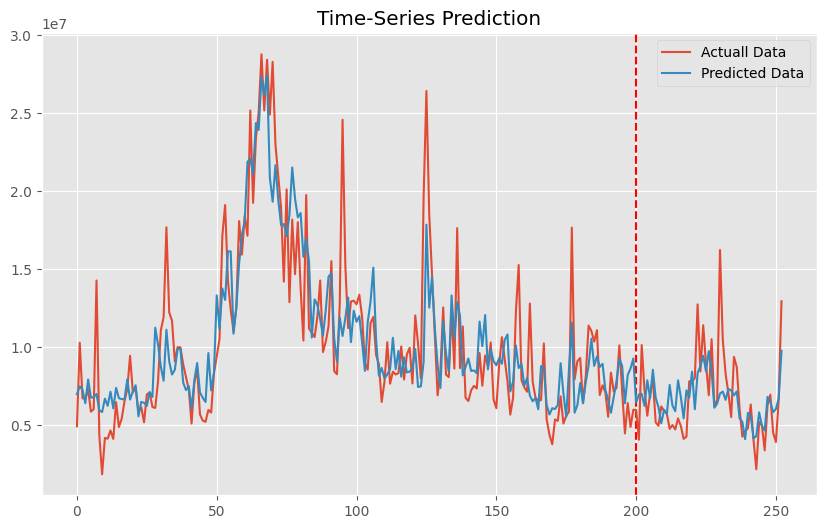

In [50]:
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=200, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 